In [1]:
import optuna
import warnings 
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer

import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, log_loss

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
train_data = pd.read_csv("./Data/train.csv").drop(columns='id')
test_data = pd.read_csv("./Data/test.csv")

In [3]:
train_data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [4]:
X = train_data.drop(columns='Status')
y = train_data['Status']

Exploratory Data Analysis 

In [5]:
X.shape, y.shape

((7905, 18), (7905,))

In [6]:
X.describe(include='all')

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,7905.000000,7905,7905.000000,7905,7905,7905,7905,7905,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000
unique,NaN,2,NaN,2,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Placebo,NaN,F,N,Y,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4010,NaN,7336,7525,4042,5966,7161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2030.173308,NaN,18373.146490,NaN,NaN,NaN,NaN,NaN,2.594485,350.561923,3.548323,83.902846,1816.745250,114.604602,115.340164,265.228969,10.629462,3.032511
std,1094.233744,NaN,3679.958739,NaN,NaN,NaN,NaN,NaN,3.812960,195.379344,0.346171,75.899266,1903.750657,48.790945,52.530402,87.465579,0.781735,0.866511
min,41.000000,NaN,9598.000000,NaN,NaN,NaN,NaN,NaN,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1230.000000,NaN,15574.000000,NaN,NaN,NaN,NaN,NaN,0.700000,248.000000,3.350000,39.000000,834.000000,75.950000,84.000000,211.000000,10.000000,2.000000
50%,1831.000000,NaN,18713.000000,NaN,NaN,NaN,NaN,NaN,1.100000,298.000000,3.580000,63.000000,1181.000000,108.500000,104.000000,265.000000,10.600000,3.000000
75%,2689.000000,NaN,20684.000000,NaN,NaN,NaN,NaN,NaN,3.000000,390.000000,3.770000,102.000000,1857.000000,137.950000,139.000000,316.000000,11.000000,4.000000


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage          7905 non-null   float64
dtypes: float

D:\Temp\ipykernel_29416\2286785528.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x ='Drug', data = X, palette = 'flare')


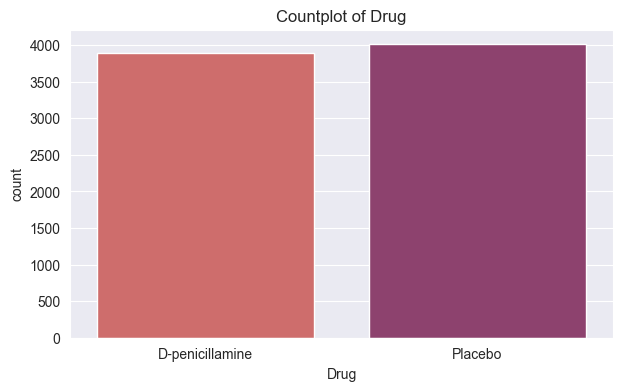

In [8]:
plt.figure(figsize=(7, 4))
sns.countplot(x ='Drug', data = X, palette = 'flare')
plt.title('Countplot of Drug')
plt.show()

D:\Temp\ipykernel_29416\1490178610.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x ='Sex', data = X, palette = 'flare')


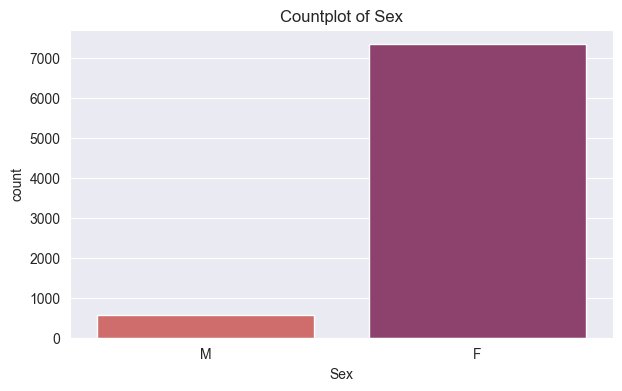

In [9]:
plt.figure(figsize=(7, 4))
sns.countplot(x ='Sex', data = X, palette = 'flare')
plt.title('Countplot of Sex')
plt.show()

D:\Temp\ipykernel_29416\2981919292.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x ='Ascites', data = X, palette = 'flare')


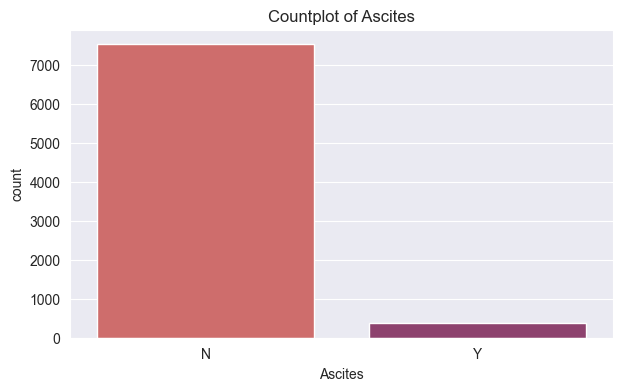

In [10]:
plt.figure(figsize=(7, 4))
sns.countplot(x ='Ascites', data = X, palette = 'flare')
plt.title('Countplot of Ascites')
plt.show()

D:\Temp\ipykernel_29416\2581094246.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x ='Hepatomegaly', data = X, palette = 'flare')


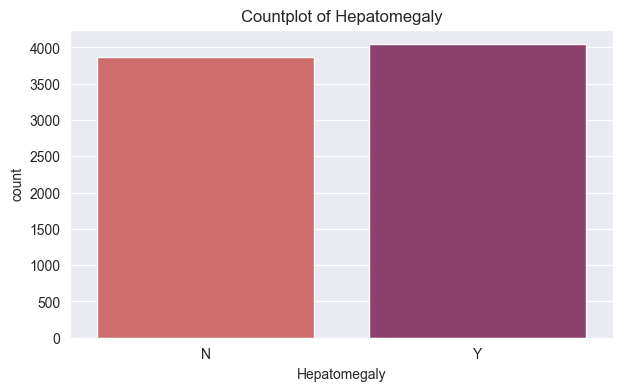

In [11]:
plt.figure(figsize=(7, 4))
sns.countplot(x ='Hepatomegaly', data = X, palette = 'flare')
plt.title('Countplot of Hepatomegaly')
plt.show()

D:\Temp\ipykernel_29416\2161553511.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x ='Spiders', data = X, palette = 'flare')


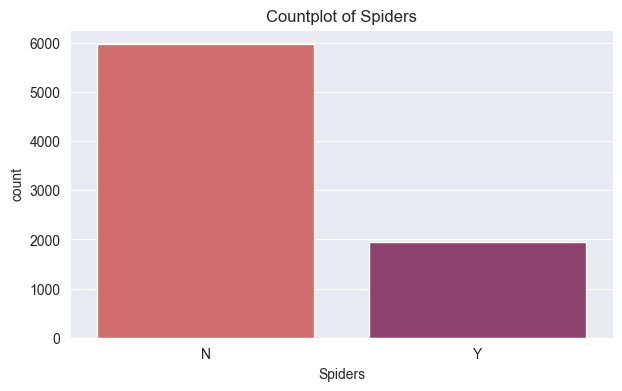

In [12]:
plt.figure(figsize=(7, 4))
sns.countplot(x ='Spiders', data = X, palette = 'flare')
plt.title('Countplot of Spiders')
plt.show()

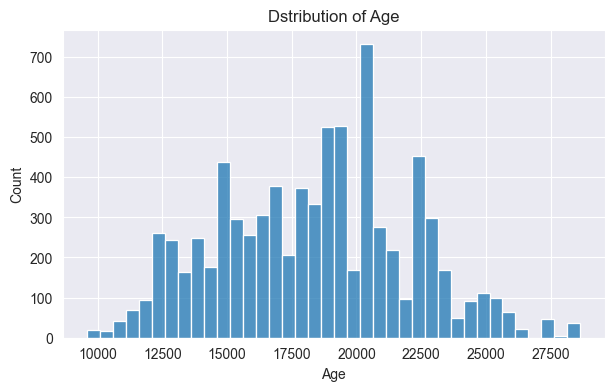

In [13]:
plt.figure(figsize=(7, 4))
sns.histplot(x ='Age', data = X)
plt.title('Dstribution of Age')
plt.show()

In [14]:
Uniq_vals = y.value_counts()
Uniq_vals

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

ValueError: Could not interpret value `Status` for `x`. An entry with this name does not appear in `data`.

<Figure size 700x400 with 0 Axes>

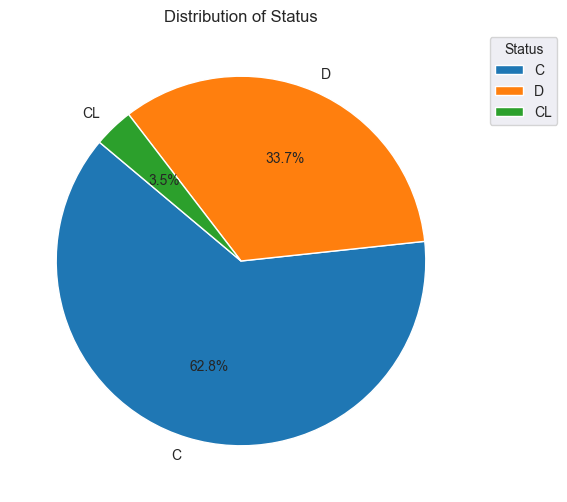

In [ ]:
# Plotting the distribution of the target variable 'Status'

LABELS = Uniq_vals.index
_y = Uniq_vals.values

# Creating autocpt arguments for pie chart
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%".format(pct)

# Creating the pie chart
plt.figure(figsize=(10, 6))
plt.pie(_y, 
        labels = LABELS, 
        autopct = lambda pct: func(pct, Uniq_vals),
        startangle = 140)

plt.legend(loc ='upper right', 
           bbox_to_anchor=(1.2, 1), 
           title='Status')

plt.title('Distribution of Status')
plt.show()

In [ ]:
X.isnull().sum()

N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

In [16]:
encoder = LabelEncoder()
X['Drug'] = encoder.fit_transform(X['Drug'])
X['Sex'] = encoder.fit_transform(X['Sex'])
X['Ascites'] = encoder.fit_transform(X['Ascites'])
X['Hepatomegaly'] = encoder.fit_transform(X['Hepatomegaly'])
X['Spiders'] = encoder.fit_transform(X['Spiders'])
X['Edema'] = encoder.fit_transform(X['Edema'])
y = encoder.fit_transform(y)

In [17]:
test_data['Drug'] = encoder.fit_transform(test_data['Drug'])
test_data['Sex'] = encoder.fit_transform(test_data['Sex'])
test_data['Ascites'] = encoder.fit_transform(test_data['Ascites'])
test_data['Hepatomegaly'] = encoder.fit_transform(test_data['Hepatomegaly'])
test_data['Spiders'] = encoder.fit_transform(test_data['Spiders'])
test_data['Edema'] = encoder.fit_transform(test_data['Edema'])

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   N_Days                 7905 non-null   int64   
 1   Drug                   7905 non-null   int32   
 2   Age                    7905 non-null   int64   
 3   Sex                    7905 non-null   int32   
 4   Ascites                7905 non-null   int32   
 5   Hepatomegaly           7905 non-null   int32   
 6   Spiders                7905 non-null   int32   
 7   Edema                  7905 non-null   int32   
 8   Bilirubin              7905 non-null   float64 
 9   Cholesterol            7905 non-null   float64 
 10  Albumin                7905 non-null   float64 
 11  Copper                 7905 non-null   float64 
 12  Alk_Phos               7905 non-null   float64 
 13  SGOT                   7905 non-null   float64 
 14  Tryglicerides          7905 non-null   f

In [38]:
RANDOM_SEED = np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [39]:
# Create the model
XGBModel = XGBClassifier()

# Fit the model
XGBModel.fit(X_train, y_train)

# Make predictions
preds = XGBModel.predict(X_test)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Age_Group: category, Cholesterol_Level: category, Tryglicerides_Level: category

In [21]:
y_pred_probs = XGBModel.predict_proba(X_test)
print('Log loss for xgb: ', log_loss(y_test, y_pred_probs))

Log loss for xgb:  0.5148158617044895


In [22]:
print("Accuracy:", accuracy_score(y_test, preds)) 
print("Precision:", precision_score(y_test, preds, average="weighted")) 
print('Recall:', recall_score(y_test, preds, average="weighted")) 

Accuracy: 0.8304870335230866
Precision: 0.8246043471460119
Recall: 0.8304870335230866


In [23]:
# Create the model
RFModel = RandomForestClassifier()

# Fit the model
RFModel.fit(X_train, y_train)

# Make predictions
preds = RFModel.predict(X_test)

In [24]:
y_pred_probs = RFModel.predict_proba(X_test)
print('Log loss for Random Forest: ', log_loss(y_test, y_pred_probs))

Log loss for Random Forest:  0.4784193731708725


In [25]:
print("Accuracy:", accuracy_score(y_test, preds)) 
print("Precision:", precision_score(y_test, preds, average="weighted")) 
print('Recall:', recall_score(y_test, preds, average="weighted")) 

Accuracy: 0.8317520556609741
Precision: 0.829749953613879
Recall: 0.8317520556609741


In [26]:
# Create the model
CatModel = CatBoostClassifier()

# Fit the model
CatModel.fit(X_train, y_train, verbose=256)

# Make predictions
preds = CatModel.predict(X_test)

Learning rate set to 0.086931
0:	learn: 1.0141600	total: 148ms	remaining: 2m 27s
256:	learn: 0.3310929	total: 960ms	remaining: 2.78s
512:	learn: 0.2520534	total: 1.82s	remaining: 1.73s
768:	learn: 0.1973412	total: 2.64s	remaining: 794ms
999:	learn: 0.1616345	total: 3.39s	remaining: 0us


In [27]:
y_pred_probs = CatModel.predict_proba(X_test)
print('Log loss for Cat Boost: ', log_loss(y_test, y_pred_probs))

Log loss for Cat Boost:  0.457848737162789


In [28]:
print("Accuracy:", accuracy_score(y_test, preds)) 
print("Precision:", precision_score(y_test, preds, average="weighted")) 
print('Recall:', recall_score(y_test, preds, average="weighted")) 

Accuracy: 0.8336495888678052
Precision: 0.8282107855796479
Recall: 0.8336495888678052


In [32]:
from logitboost import LogitBoost
Logit = LogitBoost()
Logit.fit(X_train, y_train)

pre = Logit.predict_proba(X_test)
print("Log loss for LogitBoost:", log_loss(y_test, pre))

C:\Users\李智杰\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\李智杰\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `base_estimator_` was deprecated in version 1.2 and will be removed in 1.4. Use `estimator_` instead.
  warnings.warn(msg, category=FutureWarning)


Log loss for LogitBoost: 0.7416666378500024


C:\Users\李智杰\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\李智杰\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\李智杰\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\李智杰\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but 

In [29]:
def objective(trial):
    params = {
        'objective': 'multi_logloss',
        'n_estimators': trial.suggest_int('n_estimators', 500, 700),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
    }
    
    optuna_xgbmodel = XGBClassifier(**params, random_state=RANDOM_SEED)
    optuna_xgbmodel.fit(X_train, y_train)
    y_pred_probs = optuna_xgbmodel.predict_proba(X_test)
    logloss = log_loss(y_test, y_pred_probs)
    return logloss
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-12-27 19:25:17,220] A new study created in memory with name: no-name-3cc354f8-5e11-4a09-854a-22c36b21b7a1
[I 2023-12-27 19:25:18,318] Trial 0 finished with value: 0.8810387744433441 and parameters: {'n_estimators': 500, 'learning_rate': 0.0010970949904074844, 'max_depth': 10, 'subsample': 0.597006616067252, 'colsample_bytree': 0.06792776115234445, 'min_child_weight': 13}. Best is trial 0 with value: 0.8810387744433441.
[I 2023-12-27 19:25:19,302] Trial 1 finished with value: 0.6890580783689721 and parameters: {'n_estimators': 629, 'learning_rate': 0.001491737934521878, 'max_depth': 3, 'subsample': 0.4866998063227498, 'colsample_bytree': 0.9494921310271274, 'min_child_weight': 10}. Best is trial 1 with value: 0.6890580783689721.
[I 2023-12-27 19:25:20,559] Trial 2 finished with value: 0.5261395782515094 and parameters: {'n_estimators': 507, 'learning_rate': 0.004348855783703034, 'max_depth': 6, 'subsample': 0.3380156149987747, 'colsample_bytree': 0.46265977209512826, 'min_child_

In [30]:
print('Best hyperparameters:', study.best_params)
print('Best Log Loss:', study.best_value)

Best hyperparameters: {'n_estimators': 592, 'learning_rate': 0.030327144572410022, 'max_depth': 8, 'subsample': 0.9169860207740413, 'colsample_bytree': 0.1529548628641423, 'min_child_weight': 9}
Best Log Loss: 0.42221115688323757


In [ ]:
params = study.best_params
XGBModel_2 = XGBClassifier(**params, random_state=RANDOM_SEED)

In [ ]:
XGBModel_2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.16099128241362753, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0598118447305332,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=698, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred_probs = XGBModel_2.predict_proba(X_test)
print('Log loss for tuned xgb: ', log_loss(y_test, y_pred_probs))

Log loss for tuned xgb:  0.42243817444550985


In [ ]:
XGBModel_2.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.16099128241362753, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0598118447305332,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=698, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
test_IDs = test_data['id']
test = test_data.drop(['id'], axis=1)

In [ ]:
# Make predictions on test data 
y_pred_probs = XGBModel_2.predict_proba(test)
assert y_pred_probs.shape == (test.shape[0], 3)

submission_labels = ["Status_C", "Status_CL", "Status_D"]

submission = pd.DataFrame(
                {"id": test_IDs, **dict(zip(submission_labels, y_pred_probs.T))}
)

In [ ]:
# Make predictions on test data 
y_pred_probs = CatModel.predict_proba(test)
assert y_pred_probs.shape == (test.shape[0], 3)

submission_labels = ["Status_C", "Status_CL", "Status_D"]

submission = pd.DataFrame(
                {"id": test_IDs, **dict(zip(submission_labels, y_pred_probs.T))}
)

In [ ]:
# Save a submission to csv file
submission.to_csv('./Data/submission.csv', index=False)

: 